In [26]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import time

from scipy.optimize import curve_fit

import warnings

In [27]:
dir        = "DATA/"
file1      = 'BHBH_Delay_Time.csv'

BHBH       = pd.read_csv(dir+file1)

# compute total mass and reduced mass
BHBH[  'Mass_total'] = BHBH.Mass_0 + BHBH.Mass_1
BHBH['Mass_reduced'] = BHBH.Mass_0 * BHBH.Mass_1 / (BHBH.Mass_0 + BHBH.Mass_1)

In [28]:
BHBH.head()

,Unnamed: 0.1,Unnamed: 0,Index,ID,name,BWorldtime,Mass_0,Radius_0,Zams_0,Phase_0,...,Mzams_0,Mzams_1,Semimajor_ini,Eccentricity_ini,Z,alpha,Delay_Time,Eccentricity_Delay,Mass_total,Mass_reduced
0,0,0,0,360308,0_792857804219921,5.411991,18.34303,0.000078,21.22227,7,...,41.0592,34.5745,24.874630,0.2619,0.0004,0.5,9.993410e+04,6.409107e-11,39.43934,9.811783
1,1,1,1,360337,0_285120263308905,4.134819,50.99943,0.000217,92.24360,7,...,92.2436,53.6410,81917.701038,0.3955,0.0004,0.5,5.520443e+16,4.934820e-14,102.77971,25.693444
2,2,2,2,360367,0_303570516402716,4.311590,33.98611,0.000144,41.10912,7,...,74.5563,46.8471,127.422203,0.2217,0.0004,0.5,7.108337e+05,1.981434e-10,64.82397,16.167768
3,3,3,3,360429,0_321152334354104,5.738531,42.61480,0.000181,50.85000,7,...,50.8500,32.3486,316.947946,0.0107,0.0004,0.5,1.214966e+07,2.425785e-12,75.92808,18.697151
4,4,4,4,360471,0_850952161687565,4.503749,49.74939,0.000211,65.22210,7,...,65.2221,46.7855,1548.080290,0.0751,0.0004,0.5,5.995947e+09,1.042263e-11,95.66410,23.877597


Text(0, 0.5, 'Counts')

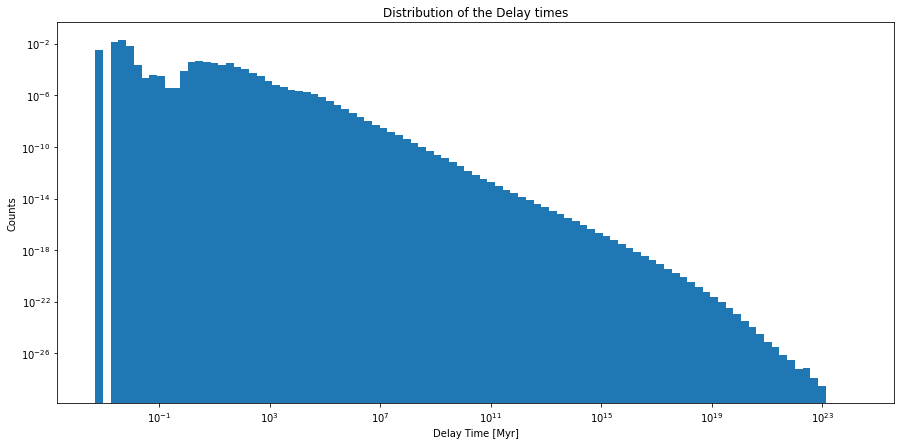

In [29]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(BHBH.Delay_Time)), np.log10(max(BHBH[(BHBH.Delay_Time<1e26)].Delay_Time)), 100)
#b = np.logspace(min(BHBH.Delay_Time), max(BHBH[(BHBH.Delay_Time<1e26)].Delay_Time), 100)
entries, edges, _ = ax.hist(BHBH[(BHBH.Delay_Time<1e26)].Delay_Time, bins=b, density=True)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

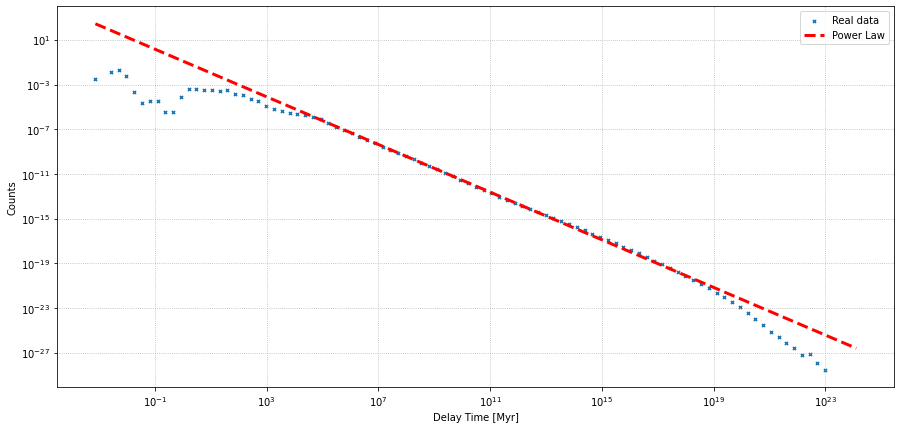

In [30]:
def power_law(x, a, b):
    return x ** a * 10 ** b

fig, ax = plt.subplots(figsize=(15,7))

# removing the first point from the fit
popt, pcov = curve_fit(power_law, bin_centers[np.where((bin_centers>1e9) & (bin_centers<1e19))], entries[np.where((bin_centers>1e9) & (bin_centers<1e19))], p0=(.005, 18))

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
ax.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]), 'r--', lw=3, label='Power Law')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()

Text(0, 0.5, 'Counts')

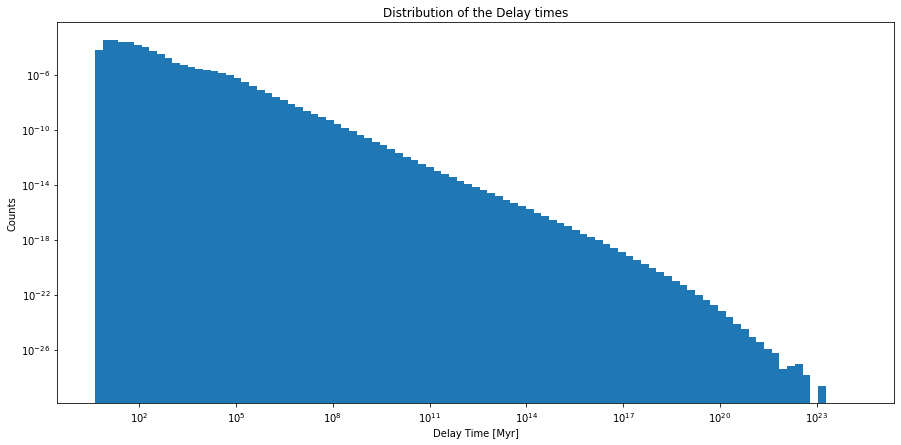

In [31]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.Delay_Time<1e18)].Delay_Time, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(BHBH.Delay_Time+BHBH.BWorldtime)), np.log10(max(BHBH.Delay_Time+BHBH.BWorldtime)), 100)
entries, edges, _ = ax.hist(BHBH.Delay_Time+BHBH.BWorldtime, bins=b, density=True)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

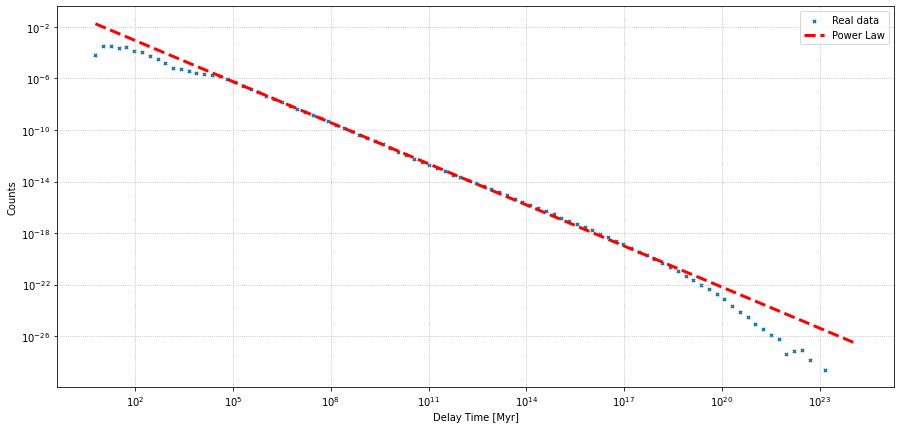

In [32]:
fig, ax = plt.subplots(figsize=(15,7))

# removing the first point from the fit
popt, pcov = curve_fit(power_law, bin_centers[np.where((bin_centers>1e9) & (bin_centers<1e19))], entries[np.where((bin_centers>1e9) & (bin_centers<1e19))], p0=(.005, 18))

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
ax.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]), 'r--', lw=3, label='Power Law')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()

Text(0, 0.5, 'Counts')

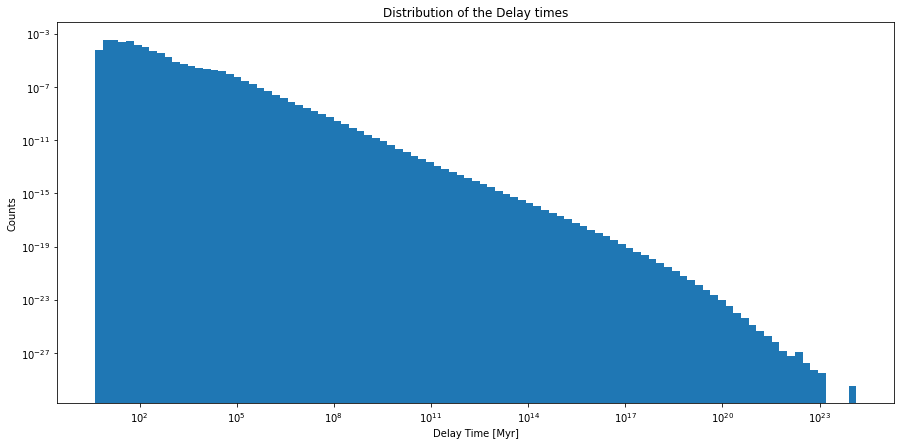

In [33]:
fig, ax = plt.subplots(figsize=(15,7))

#b = np.histogram_bin_edges(BHBH[(BHBH.GWtime<1e18)].GWtime, bins='rice') # does not work with bind='fd'
b = np.logspace(np.log10(min(BHBH.GWtime+BHBH.BWorldtime)), np.log10(max(BHBH.GWtime+BHBH.BWorldtime)), 100)
entries, edges, _ = ax.hist(BHBH.GWtime+BHBH.BWorldtime, bins=b, density=True)



# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Distribution of the Delay times')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

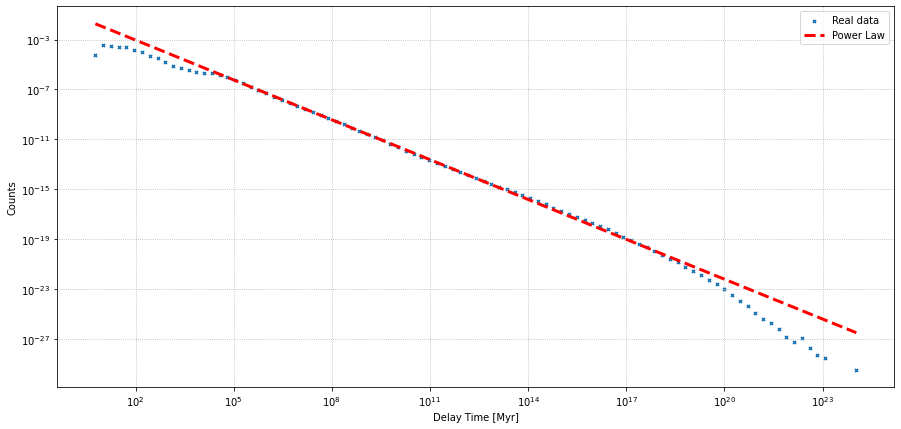

In [34]:
fig, ax = plt.subplots(figsize=(15,7))

# removing the first point from the fit
popt, pcov = curve_fit(power_law, bin_centers[np.where((bin_centers>1e9) & (bin_centers<1e19))], entries[np.where((bin_centers>1e9) & (bin_centers<1e19))], p0=(.005, 18))

ax.scatter(bin_centers, entries, s=10, marker='x', label='Real data')
ax.plot(bin_centers, power_law(bin_centers, popt[0], popt[1]), 'r--', lw=3, label='Power Law')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('Counts')

ax.grid(ls='dotted')
ax.legend(loc='upper right')

plt.show()

### Divide data in values of Z and alpha

In [35]:
# select unique values of Z and alpha
Z        = np.sort(BHBH.Z.unique())
alpha    = np.sort(BHBH.alpha.unique())

# create dict to store dataframes with unique
# values of Z and alpha
Z_df     = {elem : pd.DataFrame for elem in     Z}
alpha_df = {elem : pd.DataFrame for elem in alpha}

# fill dict's entry
for key in Z_df.keys():
    Z_df[key] = BHBH[:][BHBH.Z == key]

for key in alpha_df.keys():
    alpha_df[key] = BHBH[:][BHBH.alpha == key]

Distribution computed delay time for different values of Z

<function matplotlib.pyplot.show(close=None, block=None)>

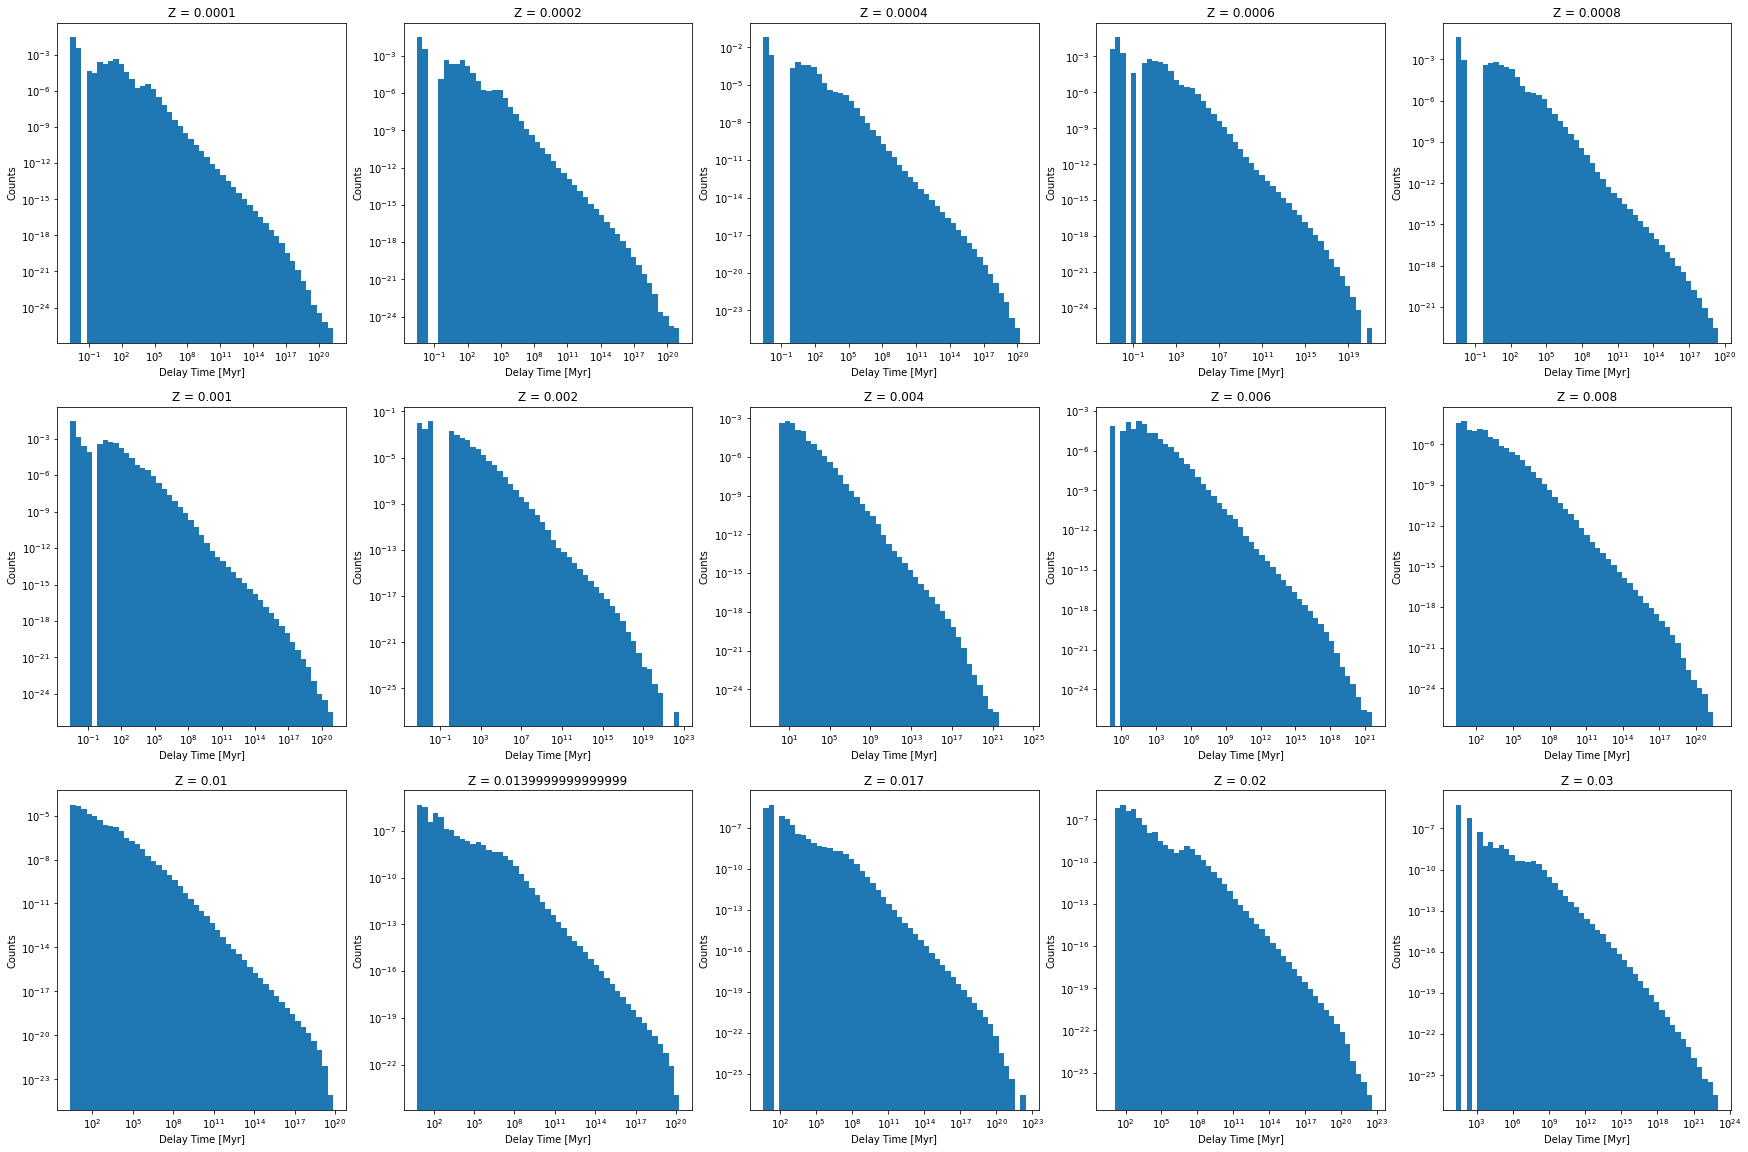

In [36]:
popt, pcov, bin_centers, entries = (np.empty(shape=(3,5), dtype=object) for i in range(4))

fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    #b                         = np.histogram_bin_edges(Z_df[key][(Z_df[key].Delay_Time<1e18)].Delay_Time, bins='rice')
    b                         = np.logspace(np.log10(min(Z_df[key].Delay_Time)), np.log10(max(Z_df[key].Delay_Time)), 50)
    entries[x,y], edges, _    = ax[x,y].hist(            Z_df[key].Delay_Time,   bins=b, density=True                 )

    # calculate bin centers
    bin_centers[x,y]          = 0.5 * (edges[:-1] + edges[1:])
    popt[x,y], pcov[x,y]      = curve_fit(power_law, bin_centers[x,y], entries[x,y], p0=(.005, 18))
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

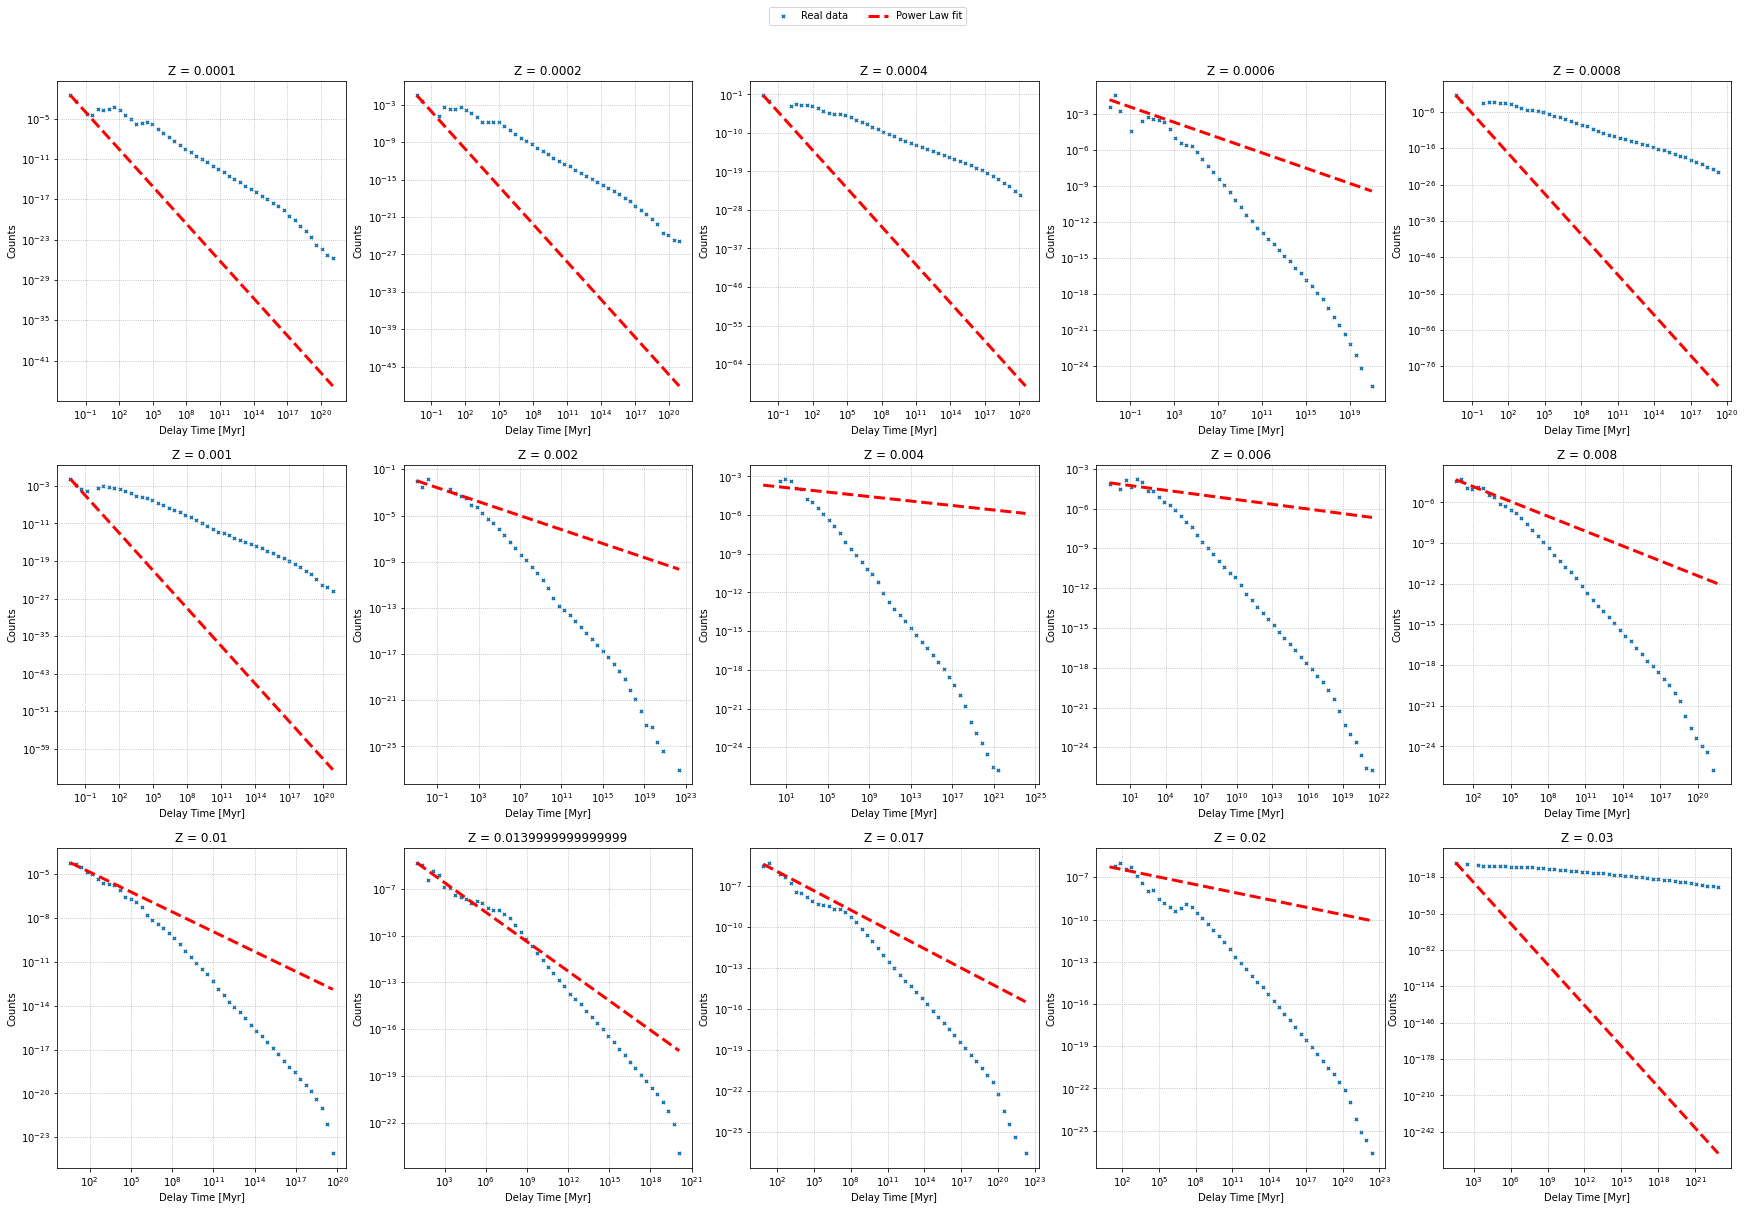

In [37]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(bin_centers[x,y], entries[x,y], s=10, marker='x')
    ax[x,y].plot(bin_centers[x,y], power_law(bin_centers[x,y], popt[x,y][0], popt[x,y][1]), 'r--', lw=3)

    ax[x,y].grid(ls='dotted')

    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

labels = ['Real data', 'Power Law fit']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

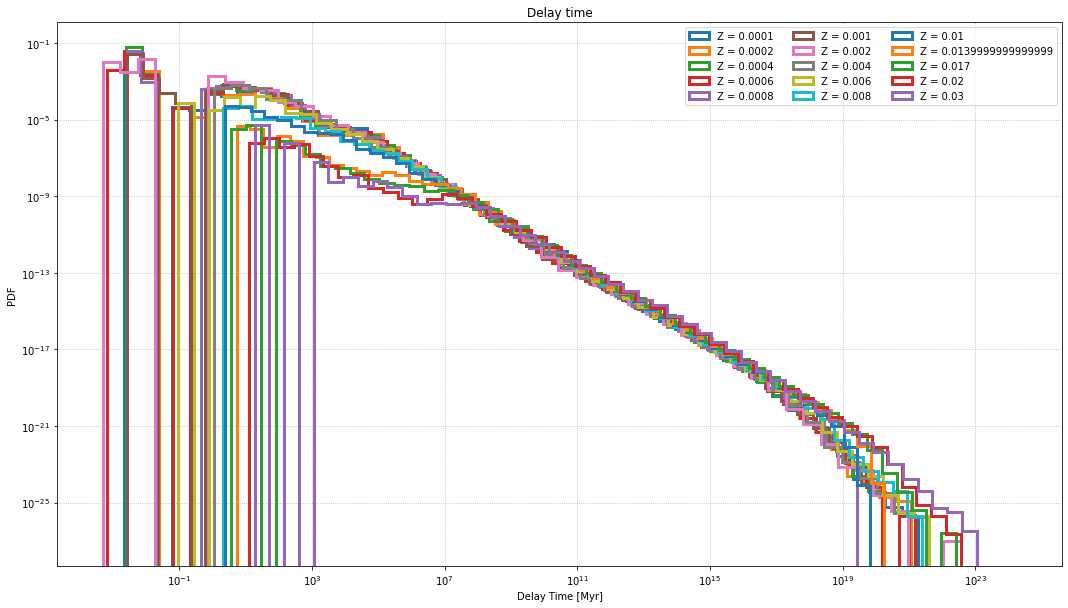

In [38]:
fig, ax = plt.subplots(figsize=(18,10))

for key in Z_df.keys():
    b                    = np.logspace(np.log10(min(Z_df[key].Delay_Time)), np.log10(max(Z_df[key].Delay_Time)),          50 )
    entries, edges, _    = ax.hist( Z_df[key].Delay_Time, bins=b, histtype='step', lw=3, label='Z = '+str(key), density=True )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Delay time')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted')
ax.legend(loc='upper right', ncol=3)
fig.savefig('figures/Delay_Time_Z.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

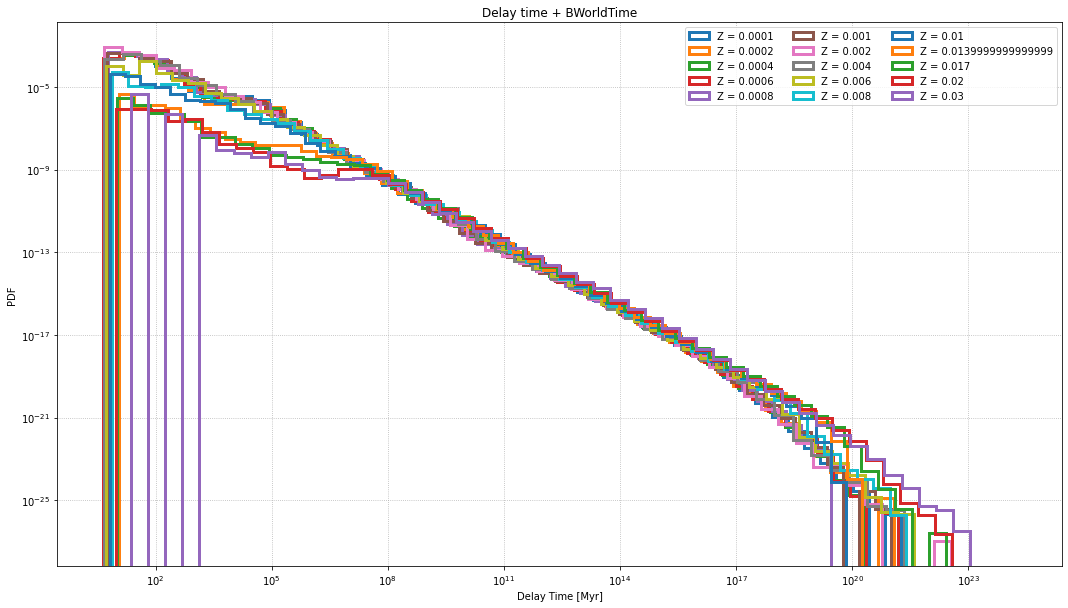

In [39]:
fig, ax = plt.subplots(figsize=(18,10))

for key in Z_df.keys():
    b                    = np.logspace(np.log10(min(Z_df[key].Delay_Time+Z_df[key].BWorldtime)), np.log10(max(Z_df[key].Delay_Time+Z_df[key].BWorldtime)), 50)
    entries, edges, _    = ax.hist( Z_df[key].Delay_Time+Z_df[key].BWorldtime, bins=b, histtype='step', lw=3, label='Z = '+str(key), density=True )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Delay time + BWorldTime')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted')
ax.legend(loc='upper right', ncol=3)
fig.savefig('figures/Delay_Time_Z_BWorldTime.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

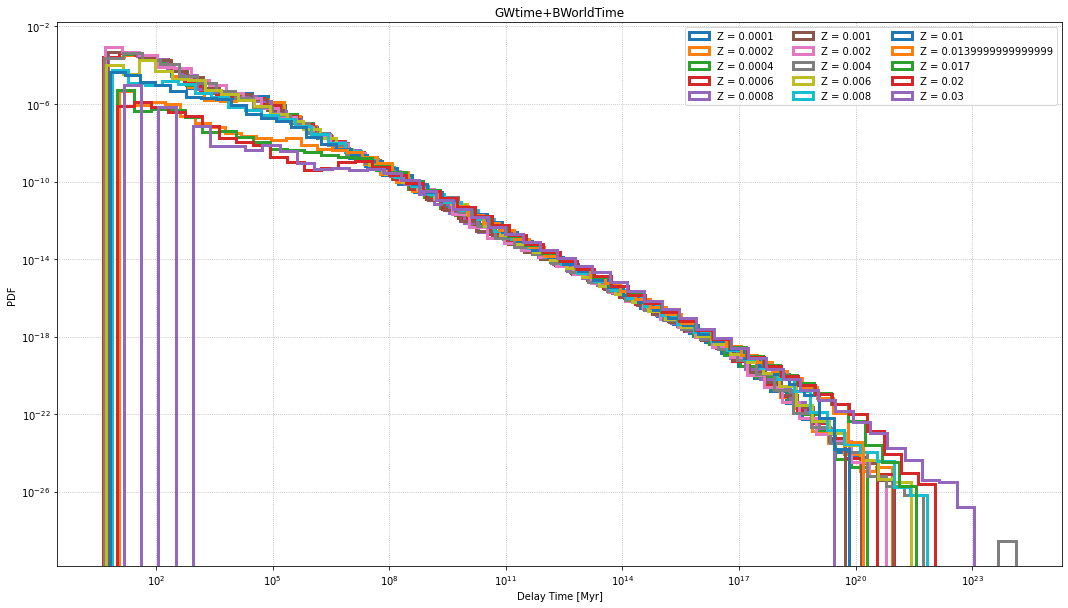

In [40]:
fig, ax = plt.subplots(figsize=(18,10))

for key in Z_df.keys():
    b                    = np.logspace(np.log10(min(Z_df[key].GWtime+Z_df[key].BWorldtime)), np.log10(max(Z_df[key].GWtime+Z_df[key].BWorldtime)), 50)
    entries, edges, _    = ax.hist( Z_df[key].GWtime+Z_df[key].BWorldtime, bins=b, histtype='step', lw=3, label='Z = '+str(key), density=True )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('GWtime+BWorldTime')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted')
ax.legend(loc='upper right', ncol=3)
fig.savefig('figures/GWtime_Z_GWtime_BWorldTime.png')
plt.show

Distribution tabulated delay time for different values of Z.

<function matplotlib.pyplot.show(close=None, block=None)>

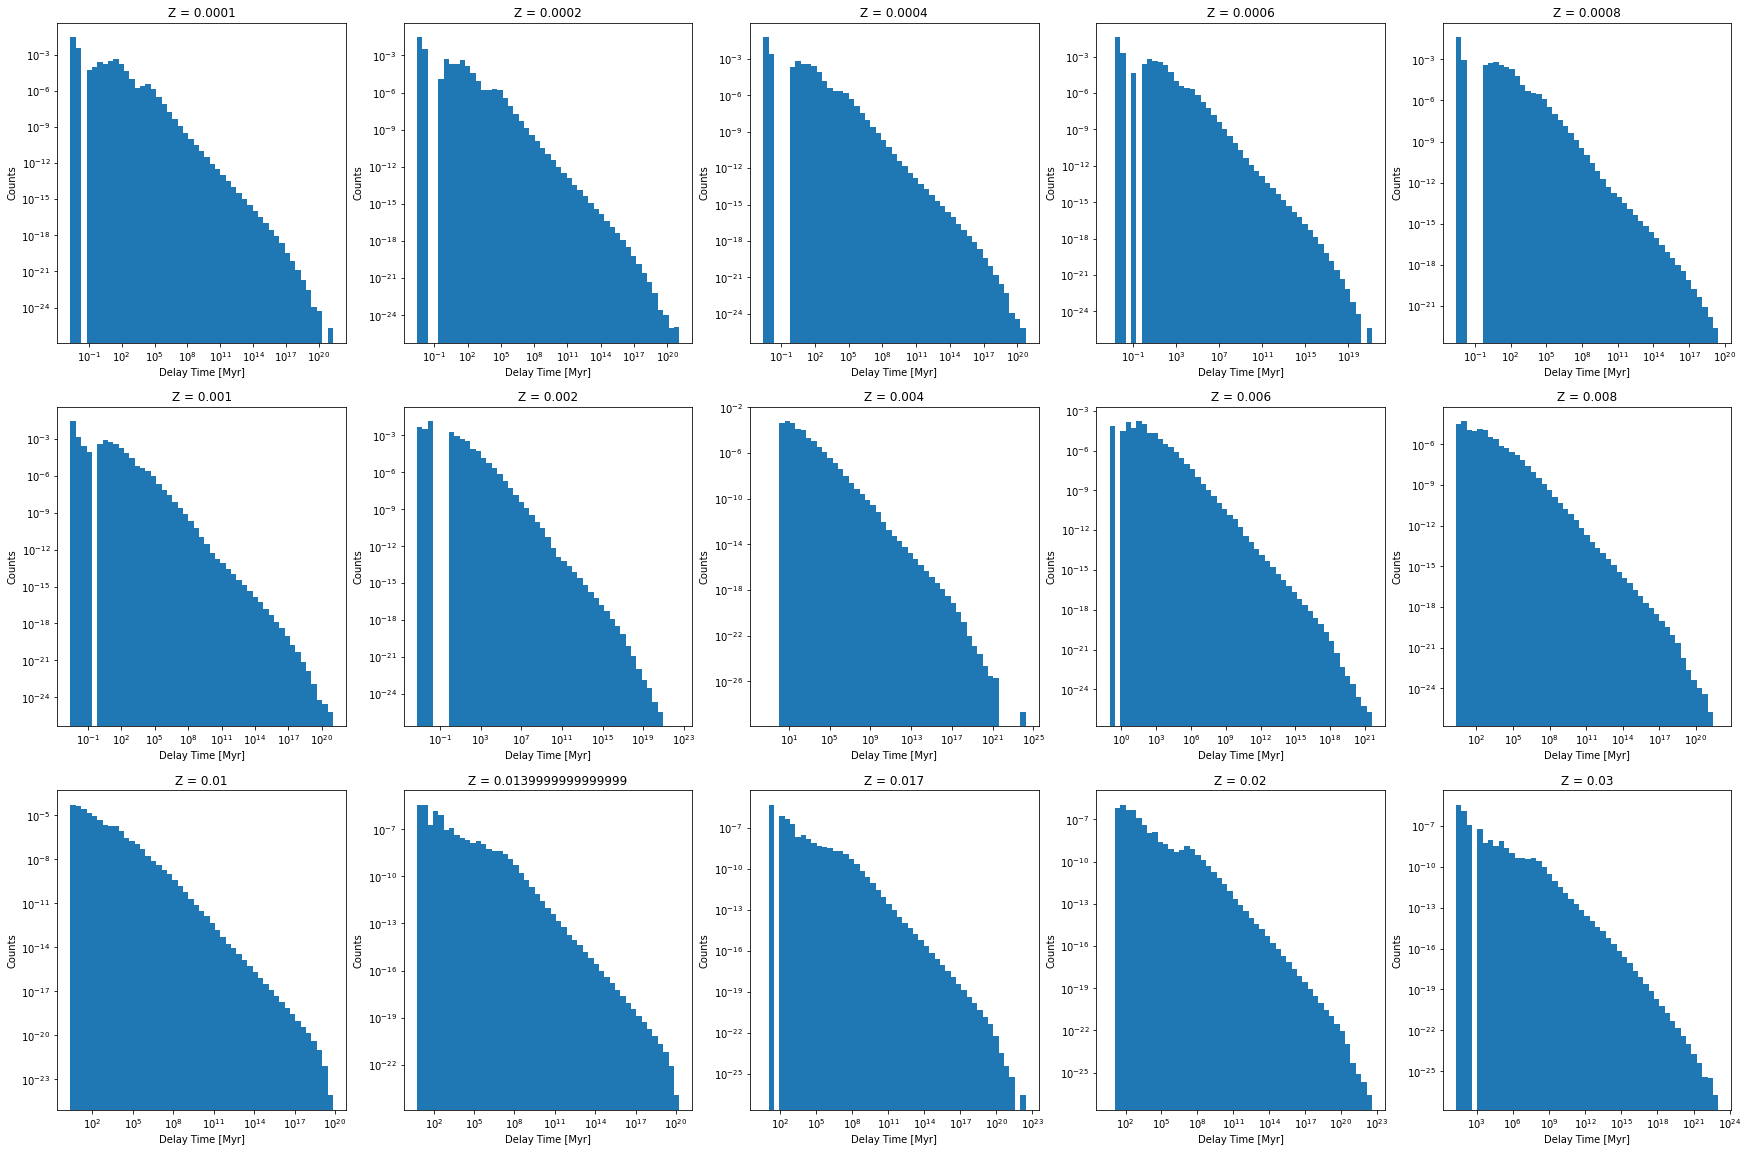

In [41]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    b = np.logspace(np.log10(min(Z_df[key].Delay_Time)), np.log10(max(Z_df[key].Delay_Time)), 50)
    ax[x,y].hist(Z_df[key].GWtime, bins=b, density=True)
    #ax[x,y].hist(Z_df[key].GWtime+Z_df[key].BWorldtime)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

Distribution computed delay time for different values of alpha

<function matplotlib.pyplot.show(close=None, block=None)>

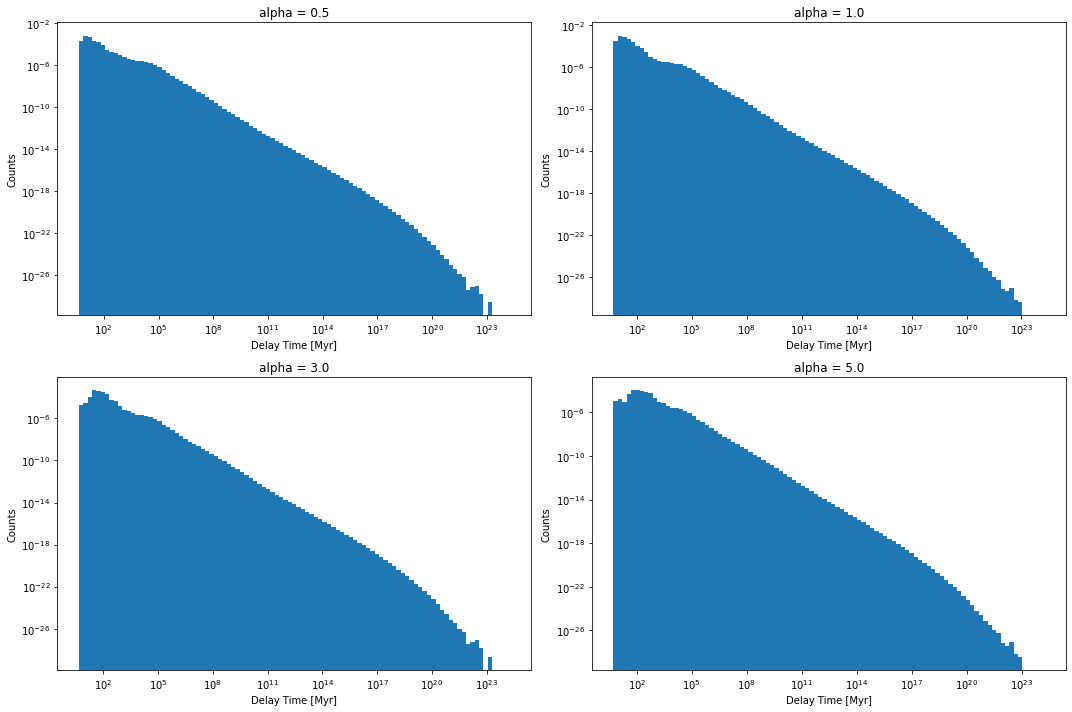

In [61]:
popt, pcov, bin_centers, entries = (np.empty(shape=(2,2), dtype=object) for i in range(4))

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    #ax[x,y].hist(alpha_df[key][(alpha_df[key].Delay_Time<1e18)].Delay_Time, bins=200)
    #b                         = np.histogram_bin_edges(alpha_df[key][(alpha_df[key].Delay_Time<1e18)].Delay_Time, bins='rice')
    b                         = np.logspace(np.log10(min(alpha_df[key].Delay_Time+alpha_df[key].BWorldtime)), np.log10(max(alpha_df[key].Delay_Time+alpha_df[key].BWorldtime)), 100)
    entries[x,y], edges, _    = ax[x,y].hist(            alpha_df[key].Delay_Time+alpha_df[key].BWorldtime, bins=b, density=True)

    # calculate bin centers
    bin_centers[x,y]          = 0.5 * (edges[:-1] + edges[1:])
    popt[x,y], pcov[x,y]      = curve_fit(power_law, bin_centers[x,y][np.where((bin_centers[x,y]>1e9) & (bin_centers[x,y]<1e19))],
                                                     entries[x,y][    np.where((bin_centers[x,y]>1e9) & (bin_centers[x,y]<1e19))], p0=(.005, 18))
    #popt[x,y], pcov[x,y]      = curve_fit(power_law, bin_centers[x,y], entries[x,y], p0=(.005, 18))

    #ax[x,y].hist(alpha_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('alpha = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('Counts')

    y += 1
    if y == 2:
        x +=1
        y = 0

fig.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

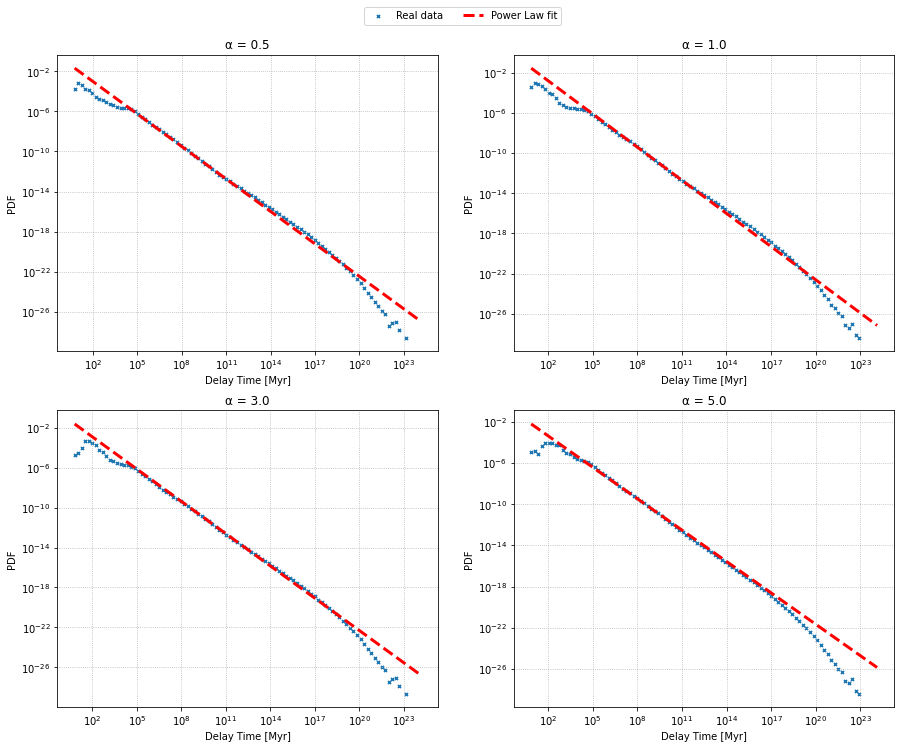

In [62]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 12))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].scatter(bin_centers[x,y], entries[x,y], s=10, marker='x')
    ax[x,y].plot(bin_centers[x,y], power_law(bin_centers[x,y], popt[x,y][0], popt[x,y][1]), 'r--', lw=3)

    ax[x,y].grid(ls='dotted')

    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('α = '+str(key))
    ax[x,y].set_xlabel('Delay Time [Myr]')
    ax[x,y].set_ylabel('PDF')

    y += 1
    if y == 2:
        x +=1
        y = 0

labels = ['Real data', 'Power Law fit']
fig.legend(labels, loc='center',bbox_to_anchor=(.5,.925), ncol=len(labels), bbox_transform=fig.transFigure)
#fig.tight_layout()
fig.savefig("figures/Fit_alpha.png")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

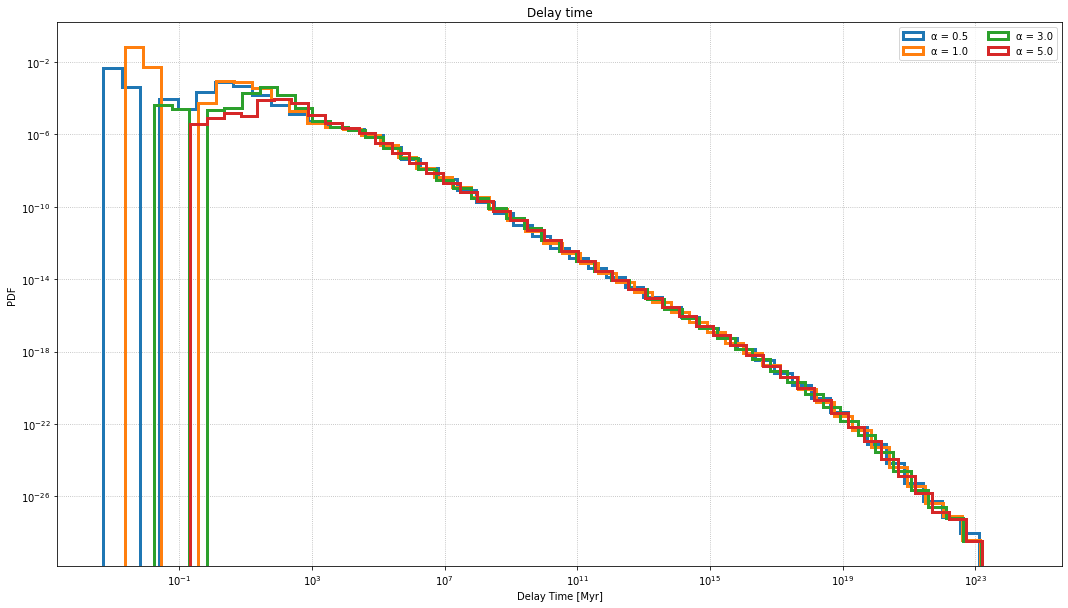

In [44]:
fig, ax = plt.subplots(figsize=(18,10))

for key in alpha_df.keys():
    b                    = np.logspace(np.log10(min(alpha_df[key].Delay_Time)), np.log10(max(alpha_df[key].Delay_Time)), 50)
    entries, edges, _    = ax.hist( alpha_df[key].Delay_Time, bins=b, histtype='step', lw=3, label='α = '+str(key), density=True )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Delay time')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted')
ax.legend(loc='upper right', ncol=2)
fig.savefig('figures/Delay_Time_alpha.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

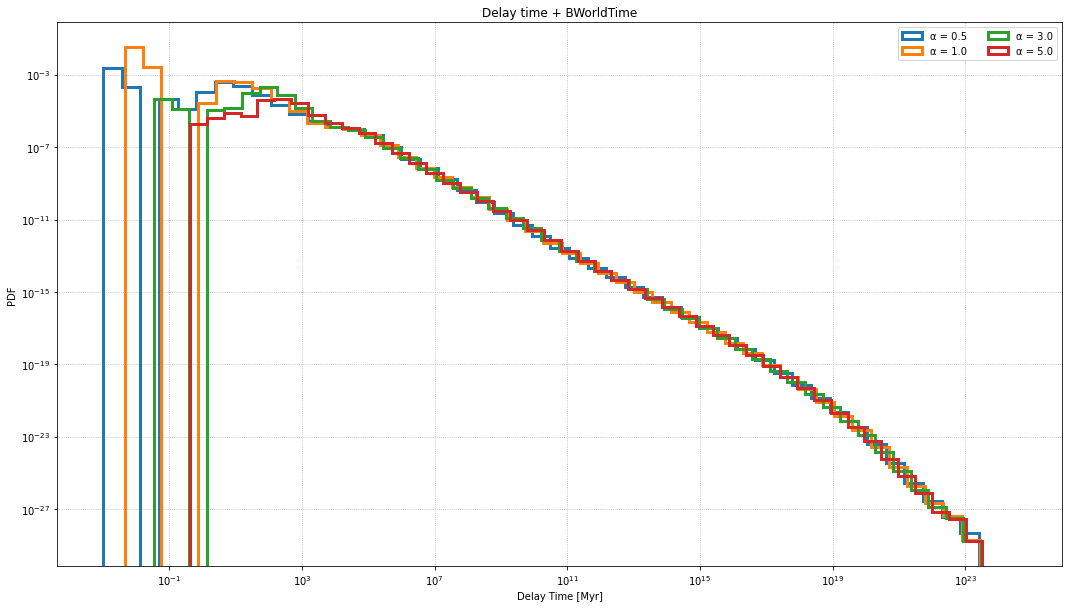

In [45]:
fig, ax = plt.subplots(figsize=(18,10))

for key in alpha_df.keys():
    b                    = np.logspace(np.log10(min(alpha_df[key].Delay_Time+alpha_df[key].Delay_Time)), np.log10(max(alpha_df[key].Delay_Time+alpha_df[key].Delay_Time)), 50)
    entries, edges, _    = ax.hist( alpha_df[key].Delay_Time+alpha_df[key].Delay_Time, bins=b, histtype='step', lw=3, label='α = '+str(key), density=True )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('Delay time + BWorldTime')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted')
ax.legend(loc='upper right', ncol=2)
fig.savefig('figures/Delay_Time_alpha_BWorldTime.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

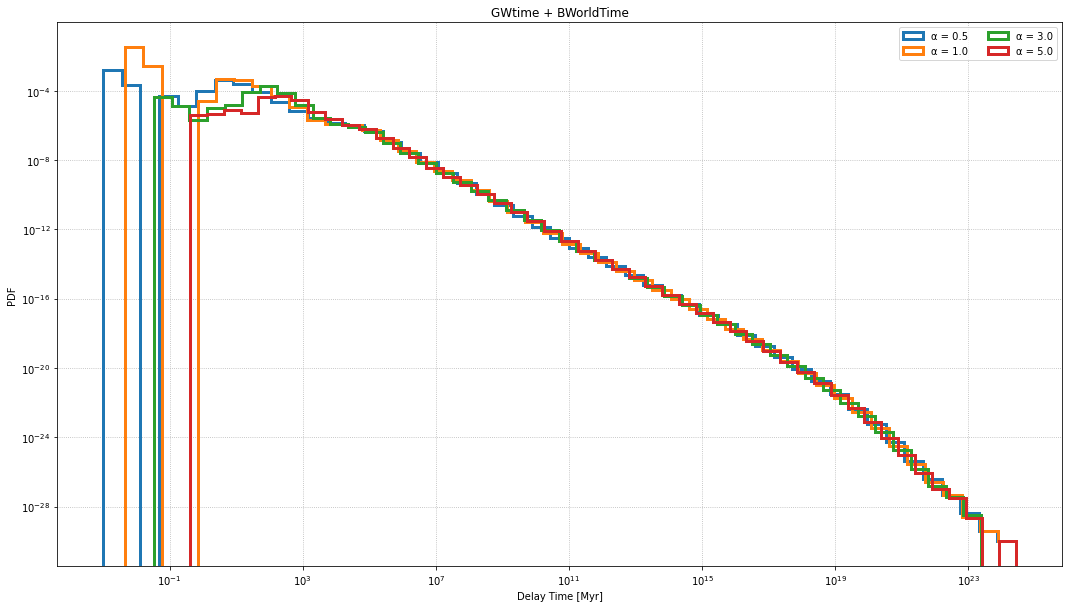

In [46]:
fig, ax = plt.subplots(figsize=(18,10))

for key in alpha_df.keys():
    b                    = np.logspace(np.log10(min(alpha_df[key].GWtime+alpha_df[key].GWtime)), np.log10(max(alpha_df[key].GWtime+alpha_df[key].GWtime)), 50)
    entries, edges, _    = ax.hist( alpha_df[key].GWtime+alpha_df[key].GWtime, bins=b, histtype='step', lw=3, label='α = '+str(key), density=True )

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_title('GWtime + BWorldTime')
ax.set_xlabel('Delay Time [Myr]')
ax.set_ylabel('PDF')
ax.grid(ls='dotted')
ax.legend(loc='upper right', ncol=2)
fig.savefig('figures/Delay_Time_alpha_GWtime_BWorldTime.png')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

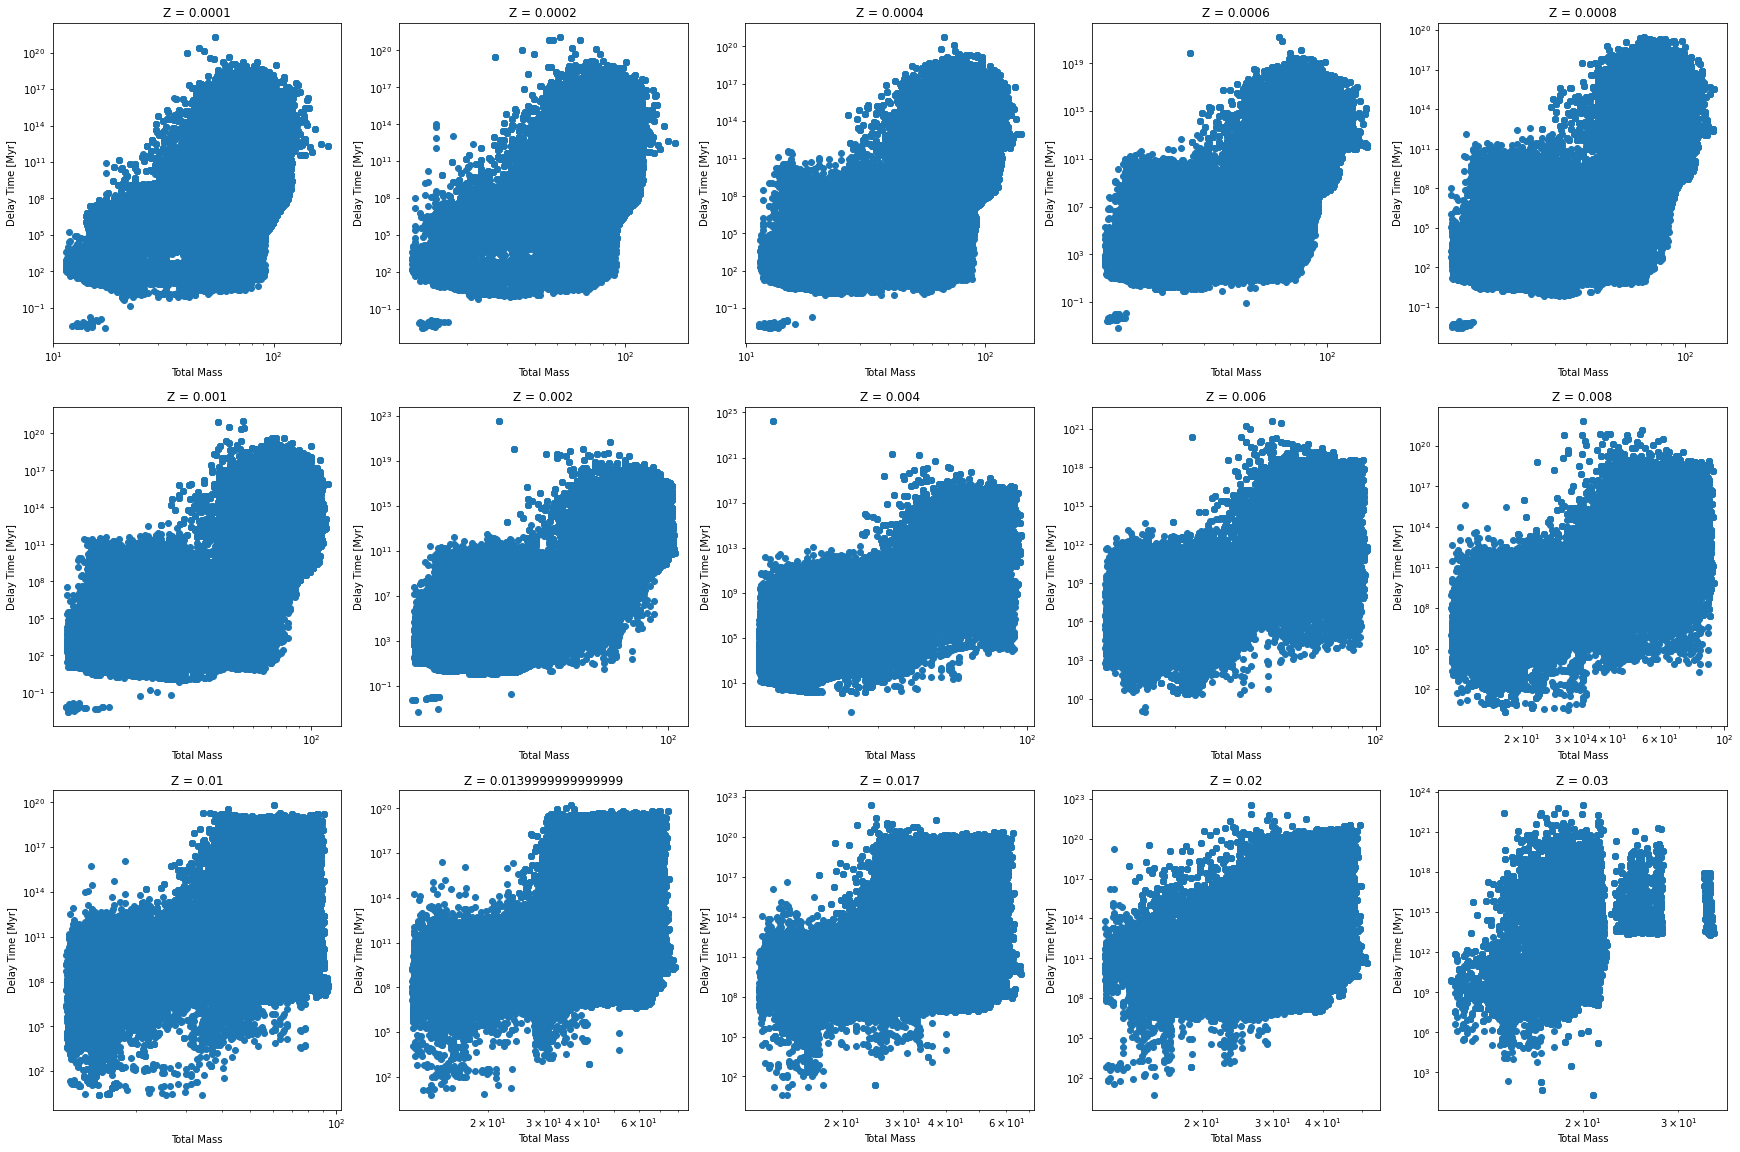

In [47]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_0+Z_df[key].Mass_1, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Total Mass')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

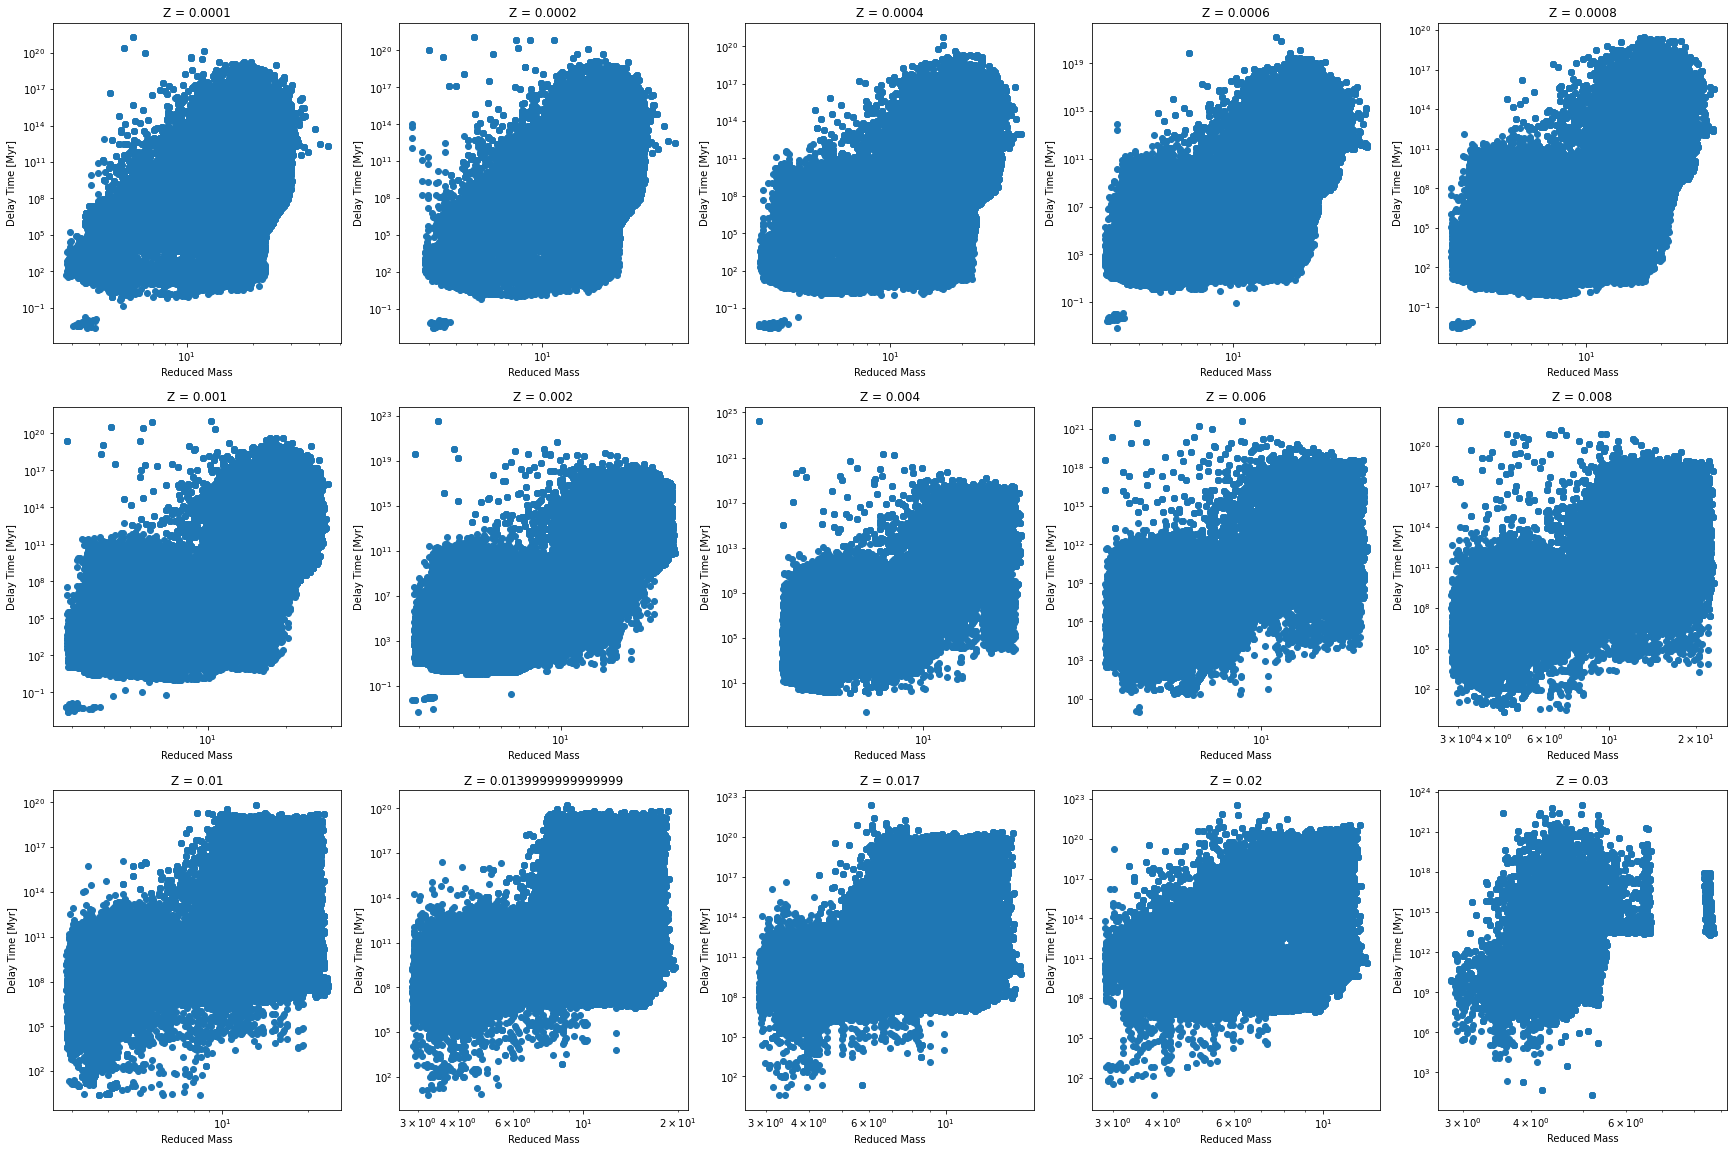

In [48]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 20))

# indexes for the plot
x, y = (0, 0)

for key in Z_df.keys():
    ax[x,y].scatter(Z_df[key].Mass_reduced, Z_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Reduced Mass')

    y += 1
    if y == 5:
        x +=1
        y = 0

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

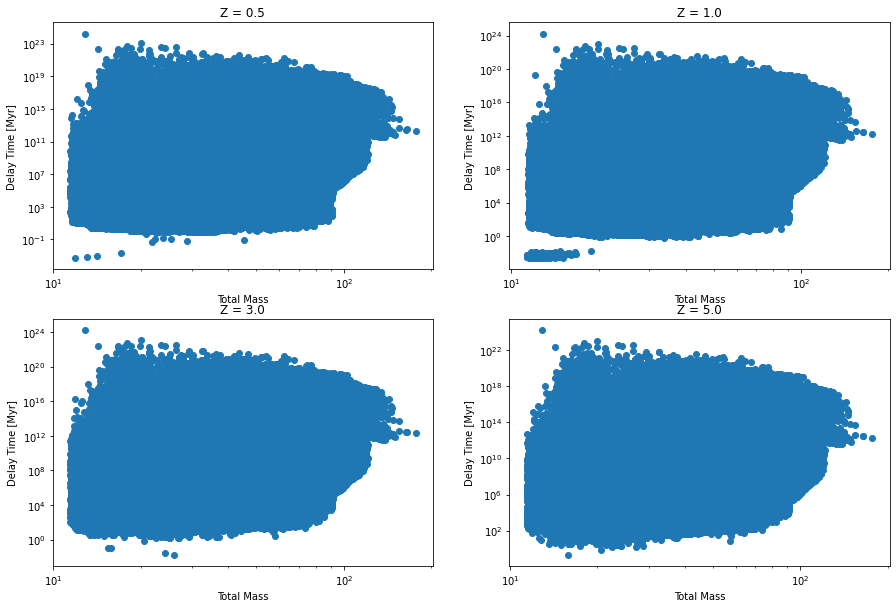

In [49]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

# indexes for the plot
x, y = (0, 0)

for key in alpha_df.keys():
    ax[x,y].scatter(alpha_df[key].Mass_0+alpha_df[key].Mass_1, alpha_df[key].Delay_Time)
    ax[x,y].set_xscale('log')
    ax[x,y].set_yscale('log')

    ax[x,y].set_title('Z = '+str(key))
    ax[x,y].set_ylabel('Delay Time [Myr]')
    ax[x,y].set_xlabel('Total Mass')

    y += 1
    if y == 2:
        x +=1
        y = 0

plt.show